# LSUN Bedrooms

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [ ]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob
from fastprogress import progress_bar
from diffusers import AutoencoderKL, UNet2DConditionModel

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


In [ ]:
import timm

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [ ]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [ ]:
bs = 64

In [ ]:
def to_img(f): return read_image(f, mode=ImageReadMode.RGB)/255

In [ ]:
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return to_img(self.files[i])[:, :256,:256]

In [ ]:
ds = ImagesDS(path/f'**/*.jpg')

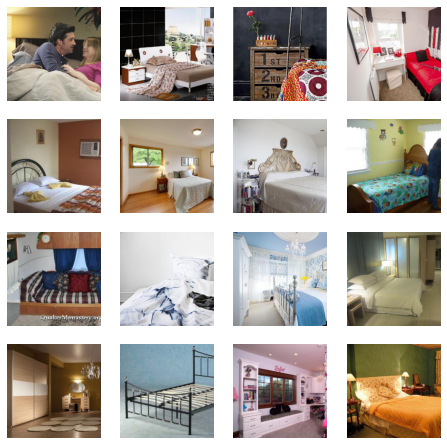

In [ ]:
dl = DataLoader(ds, batch_size=bs, num_workers=fc.defaults.cpus)
xb = next(iter(dl))
show_images(xb[:16], imsize=2)

In [ ]:
xb[:16].shape

torch.Size([16, 3, 256, 256])

In [ ]:
16*3*256*256

3145728

## VAE

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

In [ ]:
xe = vae.encode(xb.cuda())

In [ ]:
xs = xe.latent_dist.mean[:16]
xs.shape

torch.Size([16, 4, 32, 32])

In [ ]:
(16*3*256*256)/(16*4*32*32)

48.0

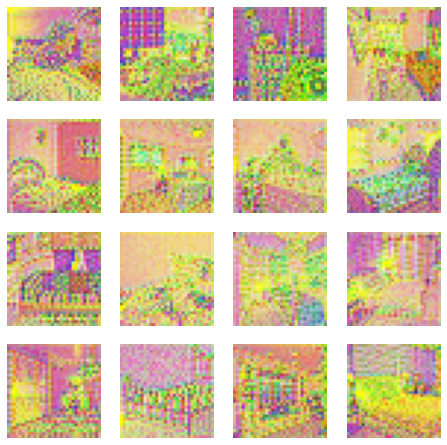

In [ ]:
show_images(((xs[:16,:3])/4).sigmoid(), imsize=2)

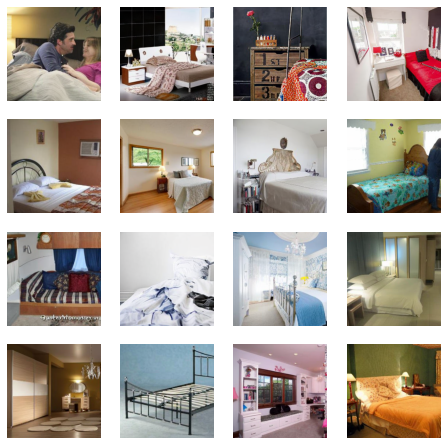

In [ ]:
xd = to_cpu(vae.decode(xs))
show_images(xd['sample'].clamp(0,1), imsize=2)

In [ ]:
mmpath = Path('data/bedroom/data.npmm')

In [ ]:
len(ds)

303125

In [ ]:
mmshape = (303125,4,32,32)

In [ ]:
if not mmpath.exists():
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for b in progress_bar(dl):
        n = len(b)
        a[i:i+n] = to_cpu(vae.encode(b.cuda()).latent_dist.mean).numpy()
        i += n
    a.flush()
    del(a)

In [ ]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape)

In [ ]:
b = torch.tensor(lats[:16])

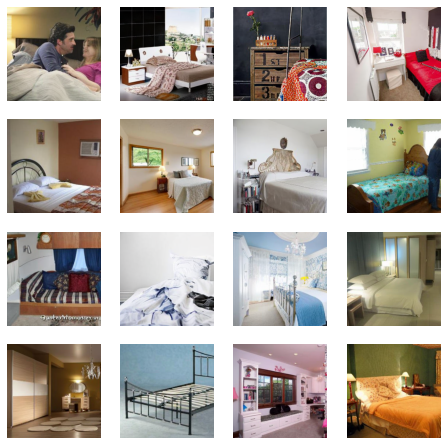

In [ ]:
xd = to_cpu(vae.decode(b.cuda()))
show_images(xd['sample'].clamp(0,1), imsize=2)

## Noisify

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)*0.2)

In [ ]:
n = len(lats)

In [ ]:
tds = lats[:n//10*9 ]
vds = lats[ n//10*9:]

In [ ]:
bs = 128

In [ ]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [ ]:
import warnings

In [ ]:
warnings.simplefilter('ignore', UserWarning)

In [ ]:
(xt,t),eps = b = next(iter(dls.train))

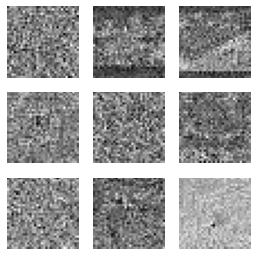

In [ ]:
show_images(xt[:9,0], imsize=1.5)

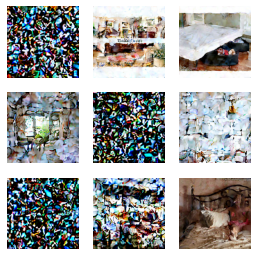

In [ ]:
xte = vae.decode(xt[:9].cuda()*5)['sample']
show_images(xte.clamp(0,1), imsize=1.5)

## Train

In [ ]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [ ]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=4, out_channels=4, nfs=(128, 256, 512, 768), num_layers=2,
                     attn_start=1, attn_chans=16)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.296,0,train
0.278,0,eval
0.271,1,train
0.269,1,eval
0.265,2,train
0.264,2,eval
0.261,3,train
0.263,3,eval
0.258,4,train
0.256,4,eval


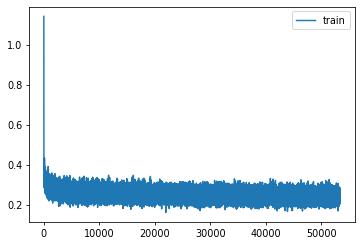

In [ ]:
learn.fit(epochs)

In [ ]:
# torch.save(learn.model.state_dict(), 'models/lsun_diffusion-latents.pkl')

## Sampling

In [ ]:
sz = (16,4,32,32)

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)

In [ ]:
s = preds[-1]*5

In [ ]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))

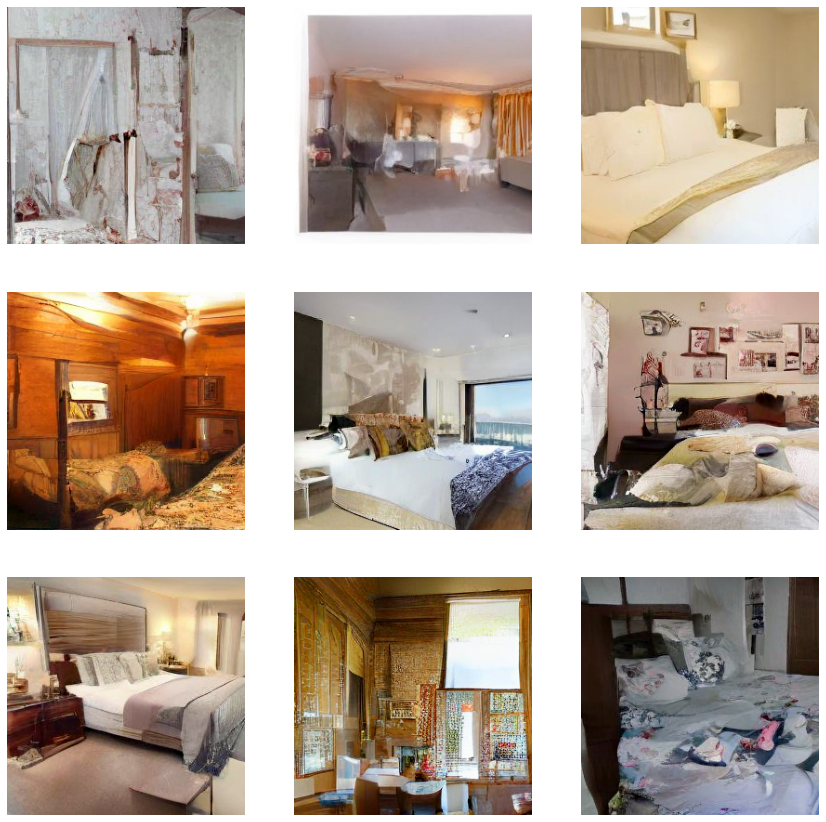

In [ ]:
show_images(pd['sample'][:9].clamp(0,1), imsize=5)